In [131]:
import numpy as np
import matplotlib.pyplot as plt
import distributions.priors as priors
import getdist
from getdist import plots, MCSamples
import h5py
import ndes.ndes as ndes
import delfi.delfi as delfi
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

In [132]:
# functions
def dp_dpar(par_grid, pdfs, i_fid, delta_i):
    
    # setup
    n_sig_8, n_sims, n_bins = pdfs.shape
    dpdpar = np.zeros(n_bins)
    
    # calculate derivatives
    for j in range(n_sims):
        dpdpar += pdfs[i_fid + delta_i, j, :] - pdfs[i_fid - delta_i, j, :]
    dpdpar /= (par_grid[i_fid + delta_i] - par_grid[i_fid - delta_i]) * n_sims

    return dpdpar

def dp_dpar_ana(par_grid, pdfs, i_fid, delta_i):
    
    # setup
    n_sig_8, n_bins = pdfs.shape
    dpdpar = np.zeros(n_bins)
    
    # calculate derivatives
    dpdpar = pdfs[i_fid + delta_i, :] - pdfs[i_fid - delta_i, :]
    dpdpar /= (par_grid[i_fid + delta_i] - par_grid[i_fid - delta_i])

    return dpdpar

def fisher_matrix(n_pix, pdf_fid, dpdpar):

    n_pix_f = float(n_pix)
    n_bins = len(dpdpar)
    f_mat = 0.0
    for k in range(n_bins):
        f_mat += (1.0 / pdf_fid[k] - 1.0 + n_pix_f) * dpdpar[k] ** 2
        others = np.array([False if m == k else \
                           True for m in range(n_bins)])
        f_mat += np.sum((n_pix_f - 1.0) * dpdpar[k] * dpdpar[others])
    f_mat *= n_pix_f
    
    return f_mat

# compressor function must have the form 
# compressor(data, args) -> compressed summaries (pseudo-MLE)
def compressor(data, args):
    
    # compress using score
    pars_fid, pdf_fid, dpdpar, f_inv = args
    d_comp = np.dot(data / pdf_fid, dpdpar)
    return pars_fid + np.dot(f_inv, d_comp)

In [133]:
# Setup
#sig_8_grid = np.linspace(sig_8_min, sig_8_max, n_sig_8)
sig_8_grid = np.array([0.735, 0.744, 0.752, 0.760, 0.768, 0.776, 0.781, 0.785, \
                       0.789, 0.793, 0.797, 0.801, 0.805, 0.809, 0.817, 0.825, \
                       0.834, 0.842, 0.850, 0.858])
sig_8_min = np.min(sig_8_grid)
sig_8_max = np.max(sig_8_grid)
temp_min = -120.0
temp_max = 0.0
temp_step = 10.
temp_bin_edges = np.arange(temp_min, temp_max, temp_step)
temp_bins = np.arange(temp_min + temp_step / 2.0, temp_max - temp_step / 2.0, temp_step)

In [160]:
# Basic pre-processing of data if needed; if not, read numerical and analytic inputs
compile_pdfs = True
if compile_pdfs:
    
    # Read in raw histograms, cut un-needed bins and renormalize to sum to 1
    n_sig_8 = 20
    n_sims = 476
    n_bins = 11
    hists = np.zeros((n_sig_8, n_sims, n_bins))
    pdfs = np.zeros((n_sig_8, n_sims, n_bins))
    for i in range(n_sig_8):
        for j in range(n_sims):
            fname = 'SZRun_sig8_{0:d}_lensedMaps_CMBplusNoise_{1:03d}.txt'.format(i, j)
            hist = np.genfromtxt('simulators/tsz_pdf/pdfs/' + fname)[0: n_bins]
            hists[i, j, :] = hist
            pdfs[i, j, :] = hist / np.sum(hist)
    with h5py.File('simulators/tsz_pdf/sig_8_sim_hists.h5', 'w') as f:
        f.create_dataset('hists', data=hists)
    
else:
    
    # Read in simulated PDFs
    with h5py.File('simulators/tsz_pdf/sig_8_sim_hists.h5', 'r') as f:
        hists = f['hists'][:]
    n_sig_8, n_sims, n_bins = hists.shape
    pdfs = np.zeros((n_sig_8, n_sims, n_bins))
    for i in range(n_sig_8):
        for j in range(n_sims):
            pdfs[i, j, :] = hists[i, j, :] / np.sum(hists[i, j, :])
    
# Read in analytical PDFs. Renormalize to sum to 1.
par_grid = []
with h5py.File('simulators/tsz_pdf/theory_pdfs.h5', 'r') as f:
    par_grid.append(f['sigma_8'][:])
    par_grid.append(f['omega_m'][:])
    par_grid.append(f['p_0'][:])
    par_grid.append(f['t_0'][:])
    inds_fid = f['par_fid_indices'][:]
    pdfs_ana = f['pdfs'][:]
for i in range(len(par_grid[0])):
    for j in range(len(par_grid[1])):
        for k in range(len(par_grid[2])):
            for l in range(len(par_grid[3])):
                pdfs_ana[i, j, k, l, :] /= np.sum(pdfs_ana[i, j, k, l, :])

In [170]:
# Calculate typical number of pixels in histogram
n_pixs = np.sum(hists, axis=-1)
n_pix = int(np.rint(np.mean(n_pixs)))
print(np.mean(n_pixs), np.std(n_pixs), n_pix)

# Renormalize all PDFs to sum to expected n_pix?
renorm = False
if renorm:
    for i in range(n_sig_8):
        for j in range(n_sims):
            hists[i, j, :] = hists[i, j, :] / np.sum(hists[i, j, :]) * n_pix
    print(np.sum(hists), n_pix * n_sig_8 * n_sims)

441685.1423319328 3060.0329293646896 441685


In [162]:
# Required components, first using numerical results
i_fid = 14
delta_i = 1
sig_8_fid = sig_8_grid[i_fid]
pdf_fid = np.mean(pdfs[i_fid, :, :], axis=0)
pdf_fid_err = np.std(pdfs[i_fid, :, :], axis=0)
dpdpar = dp_dpar(sig_8_grid, pdfs, i_fid, delta_i)
f_mat = fisher_matrix(n_pix, pdf_fid, dpdpar)
f_mat_inv = 1.0 / f_mat

# Using analytic results
pdf_fid_ana = pdfs_ana[inds_fid[0], inds_fid[1], inds_fid[2], inds_fid[3]]
dpdpar_ana = dp_dpar_ana(par_grid[0], pdfs_ana[:, inds_fid[1], inds_fid[2], inds_fid[3]], \
                         inds_fid[0], delta_i)
f_mat_ana = fisher_matrix(n_pix, pdf_fid_ana, dpdpar_ana)
f_mat_inv_ana = 1.0 / f_mat_ana

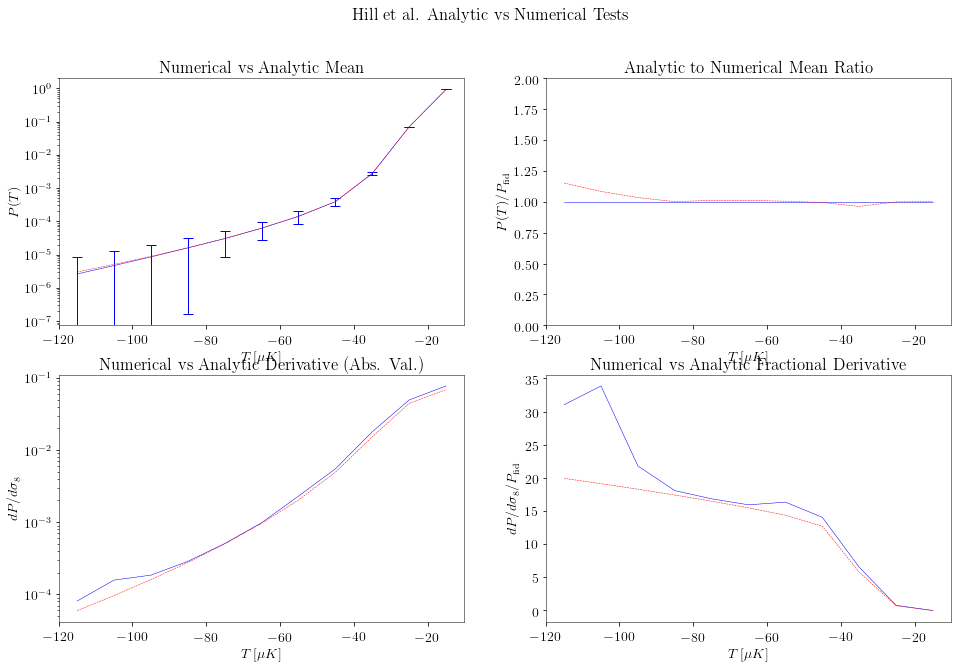

In [163]:
# Check vs analytic PDFs. Not sure how helpful this will be!
analytic_check = True
if analytic_check:
    
    '''# Find mean PDF, derivatives and Fisher matrix
    dpdpar_int = dp_dpar_ana(par_grid[0], pdfs_ana[:, inds_fid[1], inds_fid[2], inds_fid[3]], i_sig_8_int_bf, delta_i)
    f_mat_int = fisher_matrix(n_pix, pdf_fid_int, dpdpar_int)
    f_mat_int_inv = 1.0 / f_mat_int
    print(f_mat_int_inv)'''
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    #axes[0].semilogy(temp_bins, pdf_fid, 'b-')
    axes[0, 0].errorbar(temp_bins, pdf_fid, yerr=pdf_fid_err, color='b', capsize=5, elinewidth=1, markeredgewidth=1)
    axes[0, 0].semilogy(temp_bins, pdf_fid_ana, 'r--', zorder=10)
    axes[0, 0].set_ylabel(r'$P(T)$')
    axes[0, 0].set_xlabel(r'$T\,[\mu K]$')
    axes[0, 0].set_title('Numerical vs Analytic Mean')
    axes[0, 1].plot(temp_bins, pdf_fid / pdf_fid, 'b-')
    axes[0, 1].plot(temp_bins, pdf_fid_ana / pdf_fid, 'r--')
    axes[0, 1].set_ylim(0.0, 2.0)
    axes[0, 1].set_ylabel(r'$P(T)/P_{\rm fid}$')
    axes[0, 1].set_xlabel(r'$T\,[\mu K]$')
    axes[0, 1].set_title('Analytic to Numerical Mean Ratio')
    axes[1, 0].semilogy(temp_bins, np.abs(dpdpar), 'b-')
    axes[1, 0].semilogy(temp_bins, np.abs(dpdpar_ana), 'r--', zorder=10)
    axes[1, 0].set_ylabel(r'$dP/d\sigma_8$')
    axes[1, 0].set_xlabel(r'$T\,[\mu K]$')
    axes[1, 0].set_title('Numerical vs Analytic Derivative (Abs. Val.)')
    axes[1, 1].plot(temp_bins, dpdpar / pdf_fid, 'b-')
    axes[1, 1].plot(temp_bins, dpdpar_ana / pdf_fid_ana, 'r--', zorder=10)
    axes[1, 1].set_ylabel(r'$dP/d\sigma_8/P_{\rm fid}$')
    axes[1, 1].set_xlabel(r'$T\,[\mu K]$')
    axes[1, 1].set_title('Numerical vs Analytic Fractional Derivative')
    fig.suptitle('Hill et al. Analytic vs Numerical Tests')
    #plt.plot((pdfs_ana[inds_fid[0], inds_fid[1], inds_fid[2], inds_fid[3]] - pdf_fid) / pdf_fid)

In [174]:
# Compress all sims

# NOTE: The compressed summaries should be in the form of pseudo maximum-likelihood parameter estimators
# ie, if you are using the score of an approximate log-likelihood L, you should use compressed summaries
# t = \theta_\mathrm{fiducial} + F^{-1}\nabla L where F is the approximate Fisher matrix
sims_comp = np.zeros((n_sig_8 * n_sims))
sims_pars = np.zeros((n_sig_8 * n_sims))
#args = [sig_8_fid, pdf_fid, dpdpar, f_mat_inv]
args = [sig_8_fid, pdf_fid_ana, dpdpar_ana, f_mat_inv_ana]
for i in range(n_sig_8):
    for j in range(n_sims):
        ind = i * n_sims + j
        sims_comp[ind] = compressor(hists[i, j, :], args)
        sims_pars[ind] = sig_8_grid[i]
print(np.mean(sims_comp[i_fid * n_sims: (i_fid + 1) * n_sims]), sig_8_fid, \
      np.std(sims_comp[i_fid * n_sims: (i_fid + 1) * n_sims]), np.sqrt(f_mat_inv_ana))

0.819619198406298 0.817 0.01661599964515478 0.0030361639680376138


In [148]:
# Set up the truncated Gaussian prior...

# Prior parameter boundaries
lower = np.array([sig_8_min])
upper = np.array([sig_8_max])

# Prior mean and covariance
prior_mean = np.array([0.7965])
Q = np.eye(1)*np.array([0.05])**2

# Create prior over parameters
prior = priors.TruncatedGaussian(prior_mean, Q, lower, upper)

In [149]:
# Set up the Delfi object...

# Create the neural density estimator (MAF stands for Masked Autoregressive Flow)
# NOTE: n_inputs = number of parameters, n_outputs = number of compressed summaries
#NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=5, n_data=5, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
#        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
#        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
#        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
#        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
#        ndes.MixtureDensityNetwork(n_parameters=5, n_data=5, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=1, n_data=1, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0)]

# Create the DELFI object
DelfiNDE = delfi.Delfi(np.array([sims_comp[i_fid * n_sims]]), prior, NDEs, Finv=np.array([[f_mat_inv_ana]]), theta_fiducial=np.array([sig_8_fid]), 
                       param_limits = [lower, upper],
                       param_names = ['\sigma_8'], 
                       results_dir = "simulators/tsz_pdf/results_prerun/",
                       input_normalization="fisher")

# Load in the simulations
DelfiNDE.load_simulations(sims_comp[:, None], sims_pars[:, None])

In [150]:
# Do the Fisher pre-training step to initialize the network
DelfiNDE.fisher_pretraining()

In [151]:
# Train the network
DelfiNDE.train_ndes(training_data=[DelfiNDE.x_train, DelfiNDE.y_train], epochs=500, patience=20, batch_size=1000)

In [152]:
# MCMC sample the learned posterior
posterior_samples = DelfiNDE.emcee_sample(DelfiNDE.log_posterior_stacked, [DelfiNDE.posterior_samples[-i,:] for i in range(DelfiNDE.nwalkers)], burn_in_chain=100, main_chain=1000)

Removed no burn in


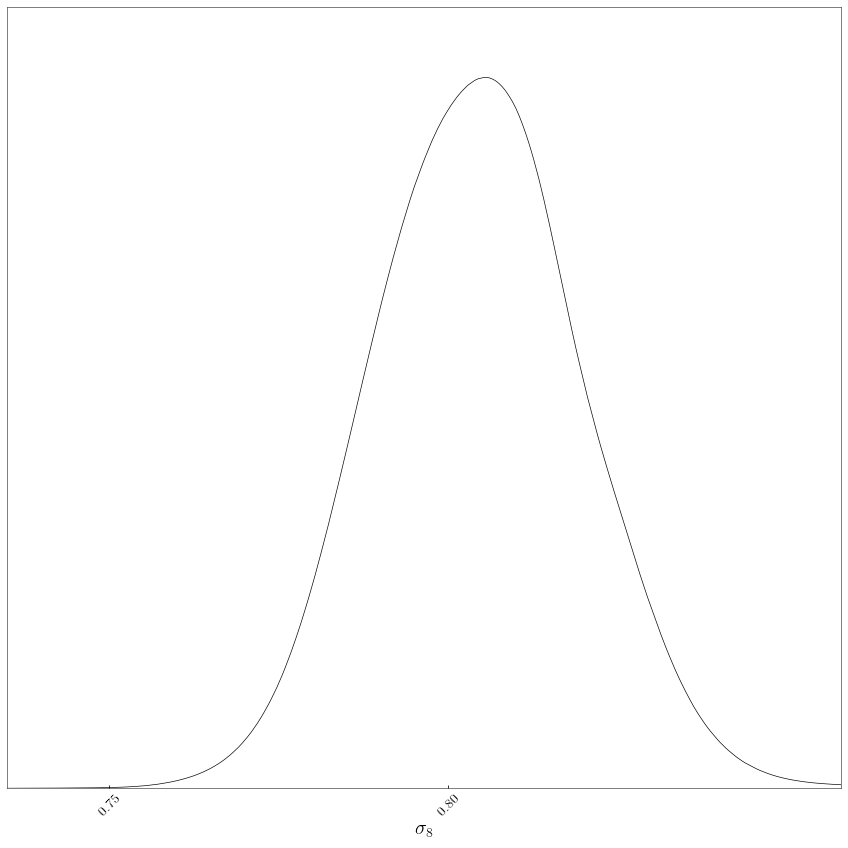

In [171]:
# Let's plot the recovered posterior

plt.close()
columnwidth = 40 # cm
aspect = 1.67*2
pts_per_inch = 72.27
inch_per_cm = 2.54
width = columnwidth/inch_per_cm
plt.rcParams.update({'figure.figsize': [width, width / aspect],
                 'backend': 'pdf',
                 'font.size': 14,
                 'legend.fontsize': 'small',
                 'legend.frameon': False,
                 'legend.loc': 'best',
                 'lines.markersize': 3,
                 'lines.linewidth': .5,
                 'axes.linewidth': .5,
                 'axes.edgecolor': 'black'})


g = plots.getSubplotPlotter(width_inch = 12)
g.settings.figure_legend_frame = False
g.settings.alpha_filled_add=0.6
g.settings.axes_fontsize=14
g.settings.legend_fontsize=16
g.settings.lab_fontsize=20

names = ['\sigma_8']
labels = ['\sigma_8']
ranges = dict(zip(names, [ [lower[i], upper[i]] for i in range(len(names)) ]))

samples = [posterior_samples]
mc_samples = [MCSamples(samples=s, names = names, labels = labels, ranges = ranges) for s in samples]

g.triangle_plot(mc_samples, normalized=True)

for i in range(0, len(names)):
    for j in range(0, i+1):
        ax = g.subplots[i,j]
        xtl = ax.get_xticklabels()
        ax.set_xticklabels(xtl, rotation=45)
        ax.set_xlim(lower[i], upper[i])
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()